Preliminaries
==============

Mount your GDrive using the file browser OR run the code below:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Topic Modeling
============

In our sessions so far, we have used a number of different textual formalisms: tokens, n-grams, documents, vector 
space models. Each has provided a unique vantage from which to begin exploring a corpus. Sometimes this vantage is 
tightly locked to the material 'thingness' of texts: tokens and n-grams, for example, help us produce metrics about 
the raw distribution of words. Others, however, were more abstract: a vector space model opens out to a view of 
textual similarity, one that touches on concepts like genre, style, or a kind of nebulous 'aboutness.'

This final chapter will work in a similar vein in its focus on topics. We know that texts are 'about' something. 
They have a particular subject; a theme; a message; an argument, even. Often, texts are about several things; a 
corpus, then, may contain dozens of contrasting themes, each of which we would want to identify – ideally at scale 
– to understand the overall contours of that corpus. Using **topic modeling**, we can infer latent structures in a 
corpus that often map onto these themes (albeit not always in a direct manner). These models produce groups, or 
topics, of related words in a corpus. Taken together, the words in each topic suggest a theme, and we can thus use 
topic modeling to probabalistically measure the association of a text with a particular topic.

As we'll discuss below, human interpretation plays a key role in this process: topic models produce textual 
structures, but it's on us to give those structures meaning. Doing so is an interative process, in which we **fine 
tune** various aspects of a model to effectively represent our corpus. This chapter will show you how to build a 
model, how to appraise it, and how to start iterating through the process of fine tuning to produce a model that 
best serves your research questions.

To do so, we'll use a corpus of book blurbs sampled from the U. Hamburg Language Technology Group's [Blurb Genre 
Collection]. The collection contains ~92,000 blurbs from Penguin Random House, ranging from Colson Whitehead's 
books to steamy supermarket romances and self-help manuals. We'll use just 1,500 – not so much that we'd be stuck 
waiting for hours for models to train, but enough to get a broad sense of different topics among the blurbs.

[Blurb Genre Collection]: https://www.inf.uni-hamburg.de/en/inst/ab/lt/resources/data/blurb-genre-collection.html

```{admonition} Learning Objectives
By the end of this chapter, you will be able to:

+ Explain what a topic model is, what it represents, and how to use one to explore a corpus
+ Build a topic model
+ Use two scoring metrics, perplexity and coherence, to appraise the quality of a model
+ Understand how to improve a model by fine tuning its number of topics and its hyperparameter values
```

Topic Modeling: Introduction
---------------------------------

```{margin} Citations
This description of topic modeling is influenced by Ted Underwood's very effective [explanation]. This [review article], from David M. Blei (one of the original developers of the method), is also quite helpful.

[explanation]: https://tedunderwood.com/2012/04/07/topic-modeling-made-just-simple-enough/
[review article]: http://www.cs.columbia.edu/~blei/papers/Blei2012.pdf
```

There are a few different flavors of topic models. We'll be using the most popular one, a **latent Dirichlet 
allocation**, or LDA, model. It involves two assumptions: 1) documents are comprised of a mixture of topics; 2) 
topics are comprised of a mixture of words. An LDA model represents these mixtures in terms of probability 
distributions: a given passage, with a given set of words, is more or less likely to be about a particular topic, 
which is in turn more or less likely to be made up of a certain grouping of words.

We initialize a model by predefining how many topics we think it should find. When the model begins training, it 
randomly guesses which words are most associated with which topic. But over the course of its training, it will 
start to keep track of the probabilities of recurrent word collocations: *river*, *bank*, and *water*, for example, 
might keep showing up together. This suggests some coherence, a possible grouping of words. A second topic, on the 
other hand, might have words like *money*, *bank*, and *robber*. The challenge here is that words belong to 
multiple topics. In this instance, given a single instance of *bank*, it could be in either the first or second 
topic. Given this, how does the model tell which topic a document containing the word *bank* is more strongly 
associated with?

It does two things. First, the model tracks how often *bank* appears with its various collocates in the corpus. If 
*bank* is generally more likely to appear with *river* and *water* than *money* and *robber*, this weights the 
probability that this particular instance of *bank* belongs to the first topic. To put a check on this weighting, 
the model also tracks how often *bank*'s collocates appear in the document in question. If, in this document, 
*river* and *water* appear more often than *robber* and *money*, then that's going to weight this instance of *bank* even further toward the first topic, not the second (it may even be that the latter two words don't appear 
in the document in all).

Using these weightings as a basis, the model will assign a probability score for a document's association with 
these two topics. This assignment will also inform the overall probability distribution of topics to words, which 
will then inform further document-topic associations, and so on. Over the course of this process, topics will 
become more consistent and focused and their associations with documents will become stronger and weaker, as 
appropriate.

Here's the formula that summarizes this process. Given topic $T$, word $W$, and document $D$, we determine the 
probability of $W$ belonging to $T$ with:

```{margin} Those two other letters...
These represent hyperparameters, which we'll discuss below.
```

$$
P(T|W,D) = \frac{\text{# of $W$ in } T + \eta_W}{\text{total tokens in } T + \eta} 
\cdot (\text{# words in $D$ that belong to } T + \alpha)
$$

More Preliminiaries
----------------

Before we begin building a model ourselves, we'll load in our data. As before, we'll use a file manifest.

In [ ]:
import pandas as pd

manifest = pd.read_csv("/content/drive/MyDrive/rbs_digital_approaches_2022/2022_data_class/tm_3/manifest.csv", index_col = 0)
manifest['PUB_DATE'] = pd.to_datetime(manifest['PUB_DATE'], format="%Y-%m-%d")

print(
    f"Number of blurbs: {len(manifest)}",
    f"\nDate range: {manifest['PUB_DATE'].dt.year.min()}--{manifest['PUB_DATE'].dt.year.max()}",
    f"\nGenres: {', '.join(manifest['GENRE'].unique().tolist())}"
)

manifest.sample(5)

In [ ]:
manifest.groupby('PUB_DATE')['ISBN'].count().plot(
    figsize = (15, 5),
    title = "Books per Year",
    xlabel = "Publication Year",
    ylabel = "Number of Books",
    ylim = (0, 11)
);

To make file loading easier, we'll isolate the file names from `manifest` and create a list of paths.

In [5]:
indir = "/content/drive/MyDrive/rbs_digital_approaches_2022/2022_data_class/tm_3/input/"
paths = indir + manifest['FILE_NAME']

Building a Topic Model
---------------------------

With this bit of preliminary work done, we're ready to build a topic model. There are numerous implementations of 
LDA modeling available, ranging from the command line utility, [MALLET] (which many of us in the DataLab use in our 
own work), to built-in APIs offered by both `gensim` and `scikit-learn`. It's tempting to use the `scikit-learn` 
API: we should be familiar with this package's conventions by now, and indeed it's quite easy to spin up a topic 
model using its API. But there's a [reported bug] in a key metric for validating LDA models in `scikit-learn`, and, 
as far as we know, this bug hasn't been fixed. Depending on your use case, this may not be a big deal. The bug has 
to do with generating a **perplexity score** from the model, which is useful for fine tuning. You, however, may not 
want to go through this process, especially if you're working in an exploratory model. In this case, it's probably 
fine to use `scikit-learn`.

As for us: we'll be demonstrating how to fine tune models and will thus avoid `scikit-learn` for the workshop. 
Instead, we'll use `tomotopy`, a Python wrapper built around Tomato, a topic modeling tool built in C++. Its API is 
fairly intuitive and comes with lots of options, which we'll leverage to build the best model possible for our 
data.

[MALLET]: https://mimno.github.io/Mallet/
[reported bug]: https://github.com/scikit-learn/scikit-learn/issues/6777

### Initializing a model

Initializing a topic model with `tomotopy` is simple: just assign `LDAModel()` to a variable and declare the number 
of topics the model will generate. As we'll discuss below, determining how many topics to use is a matter of some 
debate and complexity, but for now, we'll just pick a number and move ahead.

In [ ]:
!pip install tomotopy
import tomotopy as tp

n_topics = 5
model = tp.LDAModel(k = n_topics, seed = 357)

Now we need to add our blurbs to the model. We'll do so by using a `for` loop in conjunction with all the paths we 
created above. The only catch here is that we need to split each blurb into a list of tokens (right now they're 
stored as text blobs).

In [ ]:
for path in paths:
    with open(path, 'r') as p:
        doc = p.read().split()
        model.add_doc(doc)
        
print("Number of documents:", len(model.docs))

### Training a model

Our model is now ready to be trained. Under the hood, this happens in an iterative fashion, so we need to set the 
total number of iterations we'd like to use to do the training. With that set, it's simply a matter of calling 
`model.train()`.

```{margin} Number of iterations
Deciding on how many iterations to use can take some tweaking on real-world data. You can assume that the number 
set here will allow a model to properly [converge] for this data.

[converge]: https://docs.paperspace.com/machine-learning/wiki/convergence
```

In [9]:
model.train(iter = 500)

### Inspecting the results

With our model trained on our corpus, we can access some high-level information about the corpus.

In [ ]:
print(
    f"Number of unique words: {len(model.used_vocabs):,}",
    f"\nTotal number of tokens: {model.num_words:,}"
)

For each topic, we can get the words most associated with that topic. The accompanying score is the probability of 
that word appearing in a given topic.

In [ ]:
for k in range(model.k):
    top_words = model.get_topic_words(topic_id = k, top_n = 5)
    top_words = [f"{tup[0]} ({tup[1]:.04f}%)" for tup in top_words]
    print(
        f"Topic {k}:",
        f"\n+ {', '.join(top_words)}"
    )

This seems to make intuitive sense: we're dealing here with several hundred book blurbs, so *book*, *reader*, and 
*new* are all words we'd expect to see.

Since each topic has a probability score for every word, it's also possible to look at the total word distribution 
for a topic with `get_word_dist()`. This outputs an array of probabilities, which is indexed in the same order as 
`model.used_vocabs()`.

In [ ]:
word_dist = model.get_topic_word_dist(topic_id = 4)
pd.Series(word_dist, index = model.used_vocabs).sort_values(ascending = False).head(10)

`get_topic_dist()` performs a similar function, but for a document:

In [ ]:
random_title = manifest.sample(1).index.item()
topic_distribution = model.docs[random_title].get_topic_dist()

print(f"Topic distribution for '{manifest.loc[random_title, 'TITLE']}':")
for idx, prob in enumerate(topic_distribution):
    print(
        f"+ Topic #{idx}: {prob:0.2f}%"
    )

`tomotopy` also offers some shorthand to produce the top topics for a document. Here, we'll sample from `manifest`, 
get the associated index, pipe it into our model object, and return the top topic for a blurb.

In [ ]:
sampled_titles = manifest.sample(5).index

print("Top topics for:")
for idx in sampled_titles:
    result = model.docs[idx].get_topics(top_n = 1)
    topic = result[0][0]
    score = result[0][1]
    print(f"+ {manifest.loc[idx, 'TITLE']}: #{topic} ({score:0.2f}%)")

It's possible to get even more granular. Every word in a document has its own associated topic, which will change 
depending on the document. This is about as close to context-sensitive semantics as we can get with this method.

In [ ]:
doc = model.docs[random_title]
word_topic = pd.DataFrame(zip(doc, doc.topics), columns = ['WORD', 'TOPIC'])
word_topic.head(10)

To zoom out again: with list comprehension we can get a topic probability distribution for each document in our 
corpus. In the literature, this is called the **theta**. More informally, we refer to it as the document-topic 
matrix.

In [ ]:
import numpy as np

all_topic_distributions = [doc.get_topic_dist() for doc in model.docs]
theta = np.stack(all_topic_distributions)
theta /= theta.sum(axis = 1, keepdims = True)
theta = pd.DataFrame(
    theta,
    index = manifest['TITLE'],
    columns = list("TOPIC_" + str(i) for i in range(n_topics))
)
theta

It's also often helpful to know how "large" each topic is. There's a caveat here, however, in that each word in the 
model technically belongs to each topic, so it's somewhat of a heuristic to say that a topic's size is $n$ words. 
`tomotopy` derives the output below by multiplying each column of the theta matrix by the document lengths in the 
corpus. It then sums the results for each topic.

In [ ]:
topic_sizes = model.get_count_by_topics()

print("Number of words per topic:")
for k in range(0, n_topics):
    print(f"+ Topic #{k}: {topic_sizes[k]:,} words")

Finally, using the `num_words` attribute we can express this in terms of percentages.

In [ ]:
print("Topic proportion across the corpus:")
for k in range(0, n_topics):
    print(f"+ Topic #{k}: {topic_sizes[k] / model.num_words:0.2f}%")

Fine Tuning: The Basics
----------------------------

All this looks good so far, but our topics are fairly general. More, their total proportions across the corpus are 
relatively homogenous. Maybe this reflects what's in our corpus – or maybe not. For example, a closer inspection of 
individual word-topic distributions for a document show some mismatches between the topic, as we might interpret it 
in a general sense, and those words.

If we get the word-topic distributions from above...

In [ ]:
word_topic.head(10)

...and add in the top few words for each topic assignment...

```{margin} What this loop does
For each word in the blurb:
1. Get its associated topic
2. Get the top five words for that topic
3. Join those words into a comma-separated string
4. Append that string to a column list, which we can add to our dataframe
```

In [ ]:
top_words_column = []
for idx in word_topic.index:
    topic = word_topic.loc[idx, 'TOPIC']
    top_words = model.get_topic_words(topic, top_n = 5)
    top_words = ', '.join([w[0] for w in top_words])
    top_words_column.append(top_words)
    
word_topic['TOP_TOPIC_WORDS'] = top_words_column
word_topic.head(10)

...it would appear that the actual words in the document do not really match with the top entries for its 
associated topic. This suggests that we need to make some adjustments to the way we initialize our model so that it 
better reflects the specificis of our corpus.

But there are several different parameters to adjust when intializing the model, so what, then, should we change?

### Setting the number of topics

An easy answer would be the number of topics. If, as above, your topics seem too general, it may be because you've 
too small a number of topics for the model. Increasing the number of topics you use may make the model more 
interpretable.

We'll show an example. But before doing so, we'll load our files into a `Corpus()` object, which will streamline 
the model initialization process.

In [21]:
from tomotopy.utils import Corpus

corpus = Corpus()
for path in paths:
    with open(path, 'r') as p:
        doc = p.read().split()
        corpus.add_doc(doc)

Now, let's set a higher number of topics for our model.

In [ ]:
n_topics = 10
model_10 = tp.LDAModel(k = n_topics, corpus = corpus, seed = 357)

print("Number of documents:", len(model_10.docs))

And let's also define a quick function to help us inspect the top words for each topic. This is the same `for` loop 
we used earlier wrapped up in a callable function.

In [23]:
def print_topic_words(model, top_n = 5):
    for k in range(model.k):
        top_words = model.get_topic_words(topic_id = k, top_n = top_n)
        top_words = [f"{tup[0]} ({tup[1]:.04f}%)" for tup in top_words]
        print(
            f"Topic #{k}:",
            f"\n+ {', '.join(top_words)}"
        )

With that done, we'll train a model with our new number of topics and see what the results look like.

In [ ]:
model_10.train(iter = 500)

print_topic_words(model_10)

That looks better! Adding more topics spreads out the word distributions.

Given that, what if we increased our number of topics even higher?

In [ ]:
n_topics = 30
model_30 = tp.LDAModel(k = n_topics, corpus = corpus, seed = 357)

model_30.train(iter = 500)

print_topic_words(model_30)

This also looks pretty solid. Between the two models, there appear to be some similar topics, but the second model, 
which has a higher number of topics, includes a wider range of words in the top word distrubition. While all that 
seems well and good, we don't yet have a way to determine whether an increase in the number of topics will always 
produce more interpretable results. At some point, we might start splitting hairs. In fact, we can see this 
beginning to happen in a few instances with the second model. There are a few topics above that we might prefer to 
merge into a single one. Maybe topics 4 and 27, for example, would be better off belonging together, rather than 
staying apart, as they are here.

So the question is, what is an ideal number of topics?

One way to approach this question would be to run through a range of different topic sizes and inspect the results. 
In some cases, it can be perfectly valid to pick the number of topics that appears to be the most interpretable for 
you and the questions you have about your corpus. But there are also a few metrics we can use to measure the 
quality of a given model in terms of the underlying data it represents. Sometimes these metrics lead to models that 
aren't quite as interpretable, but they also help us make a more empirically grounded assessment of the resultant 
topics.

### Perplexity

The first of these measures is **perplexity**. In text mining and natural language processing, we use perplexity 
scoring to evaluate how well a model predicts an unseen set of words. Essentially, it measures how "surprised" a 
model is by a sequence of unseen words. The lower the perplexity, the more your model is capable of mapping 
predictions against the data it's been trained on.

```{margin} More on perplexity
If you'd like to read more on perplexity in the context of NLP, [this post] offers a good walkthrough of the 
concept and its application for the kind of work we're doing here.

[this post]: https://towardsdatascience.com/perplexity-intuition-and-derivation-105dd481c8f3
```

When you train a `tomotopy` model object, the model records a perplexity score for the training run. We can access 
this score as an attribute for a given model.

In [ ]:
print(
    f"Perplexity score for the {model_10.k}-topic model: {model_10.perplexity:0.4f}",
    f"\nPerplexity score for the {model_30.k}-topic model: {model_30.perplexity:0.4f}"
)

Interestingly, in this instance, the model with the smaller number of topics has a better perplexity score than the 
one with more topics. This would suggest that the first model is better fitted to our data and is thus a "better" 
model.

It also suggests that there may be a topic number between these two that has an even better perplexity score. We 
can test to see whether this is the case by constructing a `for` loop, in which we iterate through a range of 
different topic numbers, train a model on each, and record the resultant perplexity scores.

In [27]:
n_topic_range = range(10, 31)

perplexity_scores = []
for k in n_topic_range:
    _model = tp.LDAModel(k = k, corpus = corpus, seed = 357)
    _model.train(iter = 500)
    perplexity_scores.append({'N_TOPICS': k, 'PERPLEXITY_SCORE': _model.perplexity})

Let's convert the results to a dataframe and, while we're at it, train a model with the best-scoring number of 
topics.

In [28]:
perplexity_scores = pd.DataFrame(perplexity_scores)
perplexity_scores = perplexity_scores.sort_values('PERPLEXITY_SCORE')

best_n_topic = perplexity_scores.nsmallest(1, 'PERPLEXITY_SCORE')['N_TOPICS'].item()
best_p = tp.LDAModel(k = best_n_topic, corpus = corpus, seed = 357)
best_p.train(iter = 500)

Here are the results:

In [ ]:
perplexity_scores.head(15)

In this instance, it looks like 22 topics is the best, though the difference between the perplexity scores for that 
model and the next best-scoring model, our 10-topic model, is relatively small. Given this, if you find that a 
10-topic model is more interpretable, you may choose to make a compromise on perplexity and go with that instead.

In [ ]:
print_topic_words(best_p)

### Coherence

If you're having trouble mapping perplexity scores onto interpretable results, you might use a **coherence score** 
instead. Coherence scores measure the degree of semantic similarity among the words in a topic. Some people prefer 
to use coherence scoring in place of perplexity because these scores help distinguish the difference between topics 
that fit snugly on consistent word co-occurence and those that are artifacts of statistical inference.

There are a few ways to calculate coherence scores. We'll use `c_v` coherence, which uses the two kinds of text 
similarity we've already seen in the workshop: pointwise mutual information (PMI) and cosine similarity. This 
method takes the co-occurence counts of top words in a given topic and calculates a PMI score for each word. Then, 
it looks to every other topic in the model and calculates a PMI score for the present topic's words and those in 
the other topics. This results in a series of vectors, which are then measured with cosine similarity.

That's a mouthful, but `tomotopy` makes implementing it a breeze. Let's look at the score for the best model above.

In [ ]:
from tomotopy.coherence import Coherence

coherence = Coherence(best_p, coherence = 'c_v')
print(f"Coherence score: {coherence.get_score():.4f}")

Like with perplexity, we can construct a `for` loop and look for the best score among a set of different topic 
sizes. Here, we're looking for the highest score, which will be a number between 0 and 1.

In [32]:
n_topic_range = range(10, 31)

coherence_scores = []
for k in n_topic_range:
    _model = tp.LDAModel(k = k, corpus = corpus, seed = 357)
    _model.train(iter = 500)
    coherence = Coherence(_model, coherence = 'c_v')
    coherence_scores.append({'N_TOPICS': k, 'COHERENCE_SCORE': coherence.get_score()})

Let's format the scores, find the best one, and train a model on that.

In [ ]:
coherence_scores = pd.DataFrame(coherence_scores)
coherence_scores = coherence_scores.sort_values('COHERENCE_SCORE', ascending = False)

best_n_topic = coherence_scores.nlargest(1, 'COHERENCE_SCORE')['N_TOPICS'].item()
best_c = tp.LDAModel(k = best_n_topic, corpus = corpus, seed = 357)
best_c.train(iter = 500)

In [ ]:
coherence_scores.head(15)

Looks like a 29-topic model wins out! Here are the top words for each topic:

In [ ]:
print_topic_words(best_c)

And here's a distribution plot of the topic proportions. We'll wrap this code in a function for later comparison 
work.

```{margin} What this function does
For each topic in the model:
1. Get the top five words
2. Use string formatting in concert with `join()` to label and stringify those words
3. Append the formatted string to an empty list, which we can use as an index in a `pandas` series
4. Plot the resultant series
```

In [ ]:
def plot_topic_proportions(tm, model_name = '', top_n = 5):
    topic_proportions = tm.get_count_by_topics() / tm.num_words
    top_words = []
    for topic in range(tm.k):
        words = tm.get_topic_words(topic, top_n = top_n)
        words = f"Topic #{topic}: " + ', '.join([w[0] for w in words])
        top_words.append(words)
        
    to_plot = pd.Series(topic_proportions, index = top_words)
    to_plot = to_plot.sort_values()
    to_plot.plot.barh(
        figsize = (15,15),
        title = f"Topic Proportions for {model_name}",
        xlabel = "Topic"
    );
    
plot_topic_proportions(best_c, model_name = 'Best Coherence Model')

Fine Tuning: Advanced
---------------------------

### Hyperparameters: alpha and eta 

Clearly, there is much to consider with respect to the number of topics alone. But this number is not the only 
value we can set when initializing a model. LDA modeling has two key **hyperparameters**, which we can configure to 
more specifically control the nature of the topics a training run produces:

```{margin} Want more details?
This Stack Exchange [answer] is a remarkably succinct summary of these two hyperparameters.

[answer]: https://datascience.stackexchange.com/a/202
```

+ **Alpha**: represents document-topic density; the higher the alpha, the more evenly distributed, or "symmetric," 
  topic proportions are in a particular document; a lower alpha means topic proportions are more "asymmetric" (that 
  is, a document will have fewer predominating topics, rather than several)
+ **Eta**: represents word-topic density; the higher the eta, the more word probabilities will be distributed 
  evenly across a topic (specifically, this boosts the presence of low-probability words); a lower eta means word 
  distributions are more uneven, so each topic will have less dominant words
  
Essentially, these two hyperparameters variously control specificity in our model: one for the way our model 
handles document specificity and one for the way it handles topic specificity.

```{admonition} On terminology
Different LDA implementations have different names for these hyperparameters. Eta, for example, is also referred to 
as "beta." When reading the documentation for an implementation, look for whatever term stands for the "document 
prior" (alpha) and the "word prior" (eta).
```

`tomotopy` has actually been setting values for alpha and eta all along. If we initialize a new model, we can 
inspect their default values.

In [ ]:
model = tp.LDAModel(k = 29, corpus = corpus, seed = 357)

print(
    f"Alpha value: {model.alpha[0]:.2f}",
    f"\nEta value: {model.eta:.2f}"
)

And we can declare specific values for each using arguments in `LDAModel()`. Let's show an example. Below, we boost 
the alpha and lessen the eta. With a high alpha, we expect to create a more even distribution in topics among the 
documents, which will in turn mean each topic has more words associated with it; with a low eta, the probabilities 
for the top words within these topics should be higher.

In [ ]:
ae_adjusted = tp.LDAModel(k = 29, alpha = 1, eta = 0.001, corpus = corpus, seed = 357)
ae_adjusted.train(iter = 500)

Let's compare with the best coherence score model from above.

```{margin} What this loop does
For each model in our model dictionary:
1. Iterate through all the topics
2. Get the top five words for each topic
3. Use list comprehension to get the associated probability scores for those words
4. Print the median word count for the topics
5. Print the mean probability scores for the top words in the topic
```

In [ ]:
model_dict = {'best coherence': best_c, 'high alpha/low eta': ae_adjusted}

for name, tm in model_dict.items():
    probability_scores = []
    for topic in range(tm.k):
        words = tm.get_topic_words(topic, top_n = 5)
        scores = [w[1] for w in words]
        probability_scores.append(scores)
        
    print(
        f"For the {name} model:",
        f"\n+ Median number of words per topic:",
        f"{np.median(tm.get_count_by_topics()):.0f}",
        f"\n+ Mean probability for the top five words per topic:",
        f"{np.mean(probability_scores):0.4f}%",
        "\n"
    )

### Deciding on hyperparameter values

As with setting our number of topics, we could spend hours going back and forth between different alpha and eta 
values to determine which combination of hyperparameters is best. In the literature about LDA modeling, researchers 
have suggested various ways of setting these values programmatically. For example, the authors of [this paper] 
suggest that the ideal alpha and eta values are $\frac{50}{k}$ and 0.1, respectively (where $k$ is the number of 
topics). Alternatively, in blogs and forums like Stack Exchange, you'll often see people advocate for an approach 
called **grid searching**. This involves selecting a range of different values for the hyperparameters, permuting 
them, and building as many different models as it takes to go through all possible permutations.

Both of these approaches are reasonably valid, but they don't emphasize an important point about what our 
hyperparameters represent. Remember from above that both of them refer to _priors_, that is, to certain kinds of 
knowledge we have about our data before we even model it. In our case, we're working with a bunch of book blurbs. 
The generic conventions of blurbs are fairly constrained, so it probably doesn't make sense to raise our alpha 
values – in a sense we're already working with a "high alpha" corpus. The same might be said of a corpus of tweets 
collected around a highly specific set of keywords: in this instance, your data collection is doing the work of 
hyperparameter optimization. Put another way, _setting hyperparameters depends on your data and your research 
question(s)_. It's as valid to ask, "is this an interpretable model?", or, "does this match with what I know about 
my data?", as it is to employ perplexity scores to define a good alpha or eta.

Here's one example of what happens if you only fine tune with mathematical optimization in mind. In the model 
below, the hyperparameters are set to produce a low perplexity score with 29 topics. As it happens, this model also 
has a very high coherence score.

[this paper]: https://www.pnas.org/content/101/suppl_1/5228

In [ ]:
hyperoptimized_model = tp.LDAModel(k = 29, alpha = 5, eta = 2, corpus = corpus, seed = 357)
hyperoptimized_model.train(iter = 500)

coherence = Coherence(hyperoptimized_model, coherence = 'c_v')

print(
    f"Perplexity score: {hyperoptimized_model.perplexity:0.4f}",
    f"\nCoherence score: {coherence.get_score():0.4f}"
)

Perplexity score: 6750.9571 
Coherence score: 0.9083


Those are good looking scores, but look at the topics they produce:

In [ ]:
print_topic_words(hyperoptimized_model)

Topic #0: 
+ irrigators (0.0001%), halitosis (0.0001%), imitative (0.0001%), ranknational (0.0001%), dishonor (0.0001%)
Topic #1: 
+ sax (0.0001%), sportsreality (0.0001%), boogeymani (0.0001%), entrepreneurship (0.0001%), mathers (0.0001%)
Topic #2: 
+ succulent (0.0001%), toast (0.0001%), life (0.0001%), reunió (0.0001%), sueño (0.0001%)
Topic #3: 
+ new (0.0001%), book (0.0001%), life (0.0001%), time (0.0001%), world (0.0001%)
Topic #4: 
+ new (0.0056%), book (0.0053%), life (0.0050%), time (0.0039%), world (0.0037%)
Topic #5: 
+ languish (0.0001%), hypoglycemia (0.0001%), traced (0.0001%), romagna (0.0001%), heavenly (0.0001%)
Topic #6: 
+ palasts (0.0001%), puzzler (0.0001%), supersede (0.0001%), indicates (0.0001%), backbone (0.0001%)
Topic #7: 
+ slaveholder (0.0001%), kazuhiko (0.0001%), bunniculalooks (0.0001%), calliope (0.0001%), tehranthe (0.0001%)
Topic #8: 
+ burr (0.0001%), albino (0.0001%), annointed (0.0001%), conceivable (0.0001%), yates (0.0001%)
Topic #9: 
+ writerm

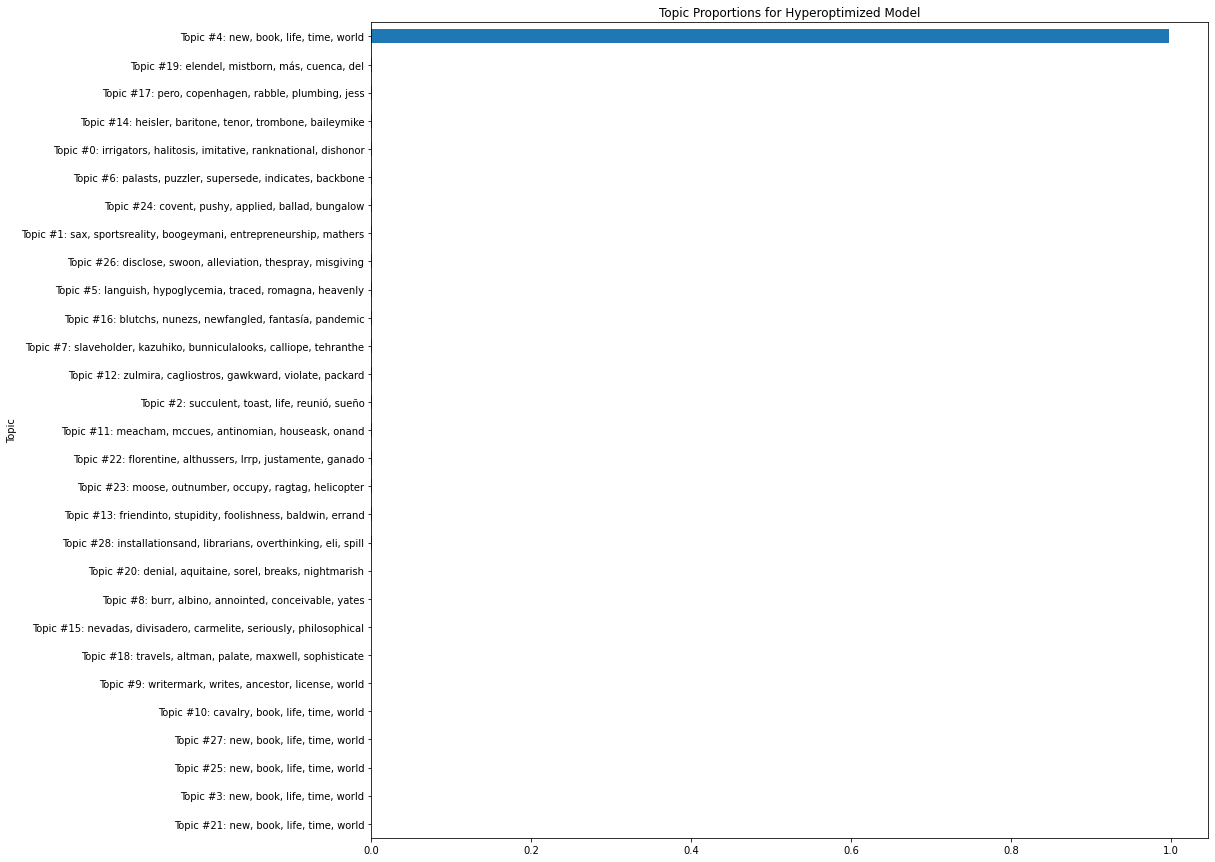

In [ ]:
plot_topic_proportions(hyperoptimized_model, model_name = 'Hyperoptimized Model')

Pretty rotten! One topic all but completely dominates the topic distribution and the others are, well, strange. 
They seem to be registering highly specific words within certain blurbs, almost at random.

The challenge of setting your hyperparameters, then, is that it's a balancing act. In light of the above output, 
for example, you might decide to favor interpretability above everything else. But doing so can lead you to 
overfitting your model. A model built on the principle of interpretability alone might only ever show you what you 
expect to find. Hence the balancing act: the whole process of fine tuning involves incorporating a number of 
different considerations (and compromises!) that, at the end of the day, should always work in the service of your 
research question – that is, the very reason you want to build a model in the first place!

To return to the question of our own corpus, we won't change much in our hyperparameters. Again, blurbs are a 
fairly constrained genre, so what we'll do is slightly roll off the alpha value. This will help emphasize specific 
document-topic connections, which may help us understand some of the different document types in the corpus. We'll 
stick with the 29 topic model, as it strikes a good balance between perplexity/coherence scoring and general spread 
among the topics themselves. As for eta, we'll leave it alone.

In [ ]:
tuned = tp.LDAModel(k = 29, alpha = 0.08, eta = 0.01, corpus = corpus, seed = 357)
tuned.train(iter = 500)

coherence_model = Coherence(tuned, coherence = 'c_v')

print(
    f"Perplexity score: {tuned.perplexity:0.4f}",
    f"\nCoherence score: {coherence_model.get_score():0.4f}"
)

Perplexity score: 9867.0200 
Coherence score: 0.6443


In [ ]:
print_topic_words(tuned)

Topic #0: 
+ home (0.0305%), cat (0.0217%), friend (0.0179%), dog (0.0156%), city (0.0137%)
Topic #1: 
+ new (0.0397%), time (0.0337%), book (0.0335%), york (0.0307%), award (0.0179%)
Topic #2: 
+ woman (0.0549%), life (0.0210%), relationship (0.0191%), mother (0.0171%), husband (0.0171%)
Topic #3: 
+ new (0.0268%), just (0.0194%), time (0.0182%), make (0.0139%), like (0.0121%)
Topic #4: 
+ life (0.0245%), spiritual (0.0196%), live (0.0192%), art (0.0159%), practice (0.0139%)
Topic #5: 
+ vampire (0.0162%), financial (0.0149%), rule (0.0128%), money (0.0128%), crisis (0.0081%)
Topic #6: 
+ new (0.0271%), man (0.0143%), magic (0.0138%), tale (0.0133%), return (0.0130%)
Topic #7: 
+ book (0.0164%), use (0.0128%), learn (0.0116%), show (0.0108%), offer (0.0101%)
Topic #8: 
+ classic (0.0284%), work (0.0241%), penguin (0.0228%), text (0.0172%), year (0.0172%)
Topic #9: 
+ life (0.0333%), story (0.0247%), world (0.0184%), year (0.0172%), man (0.0110%)
Topic #10: 
+ music (0.0242%), star (0.

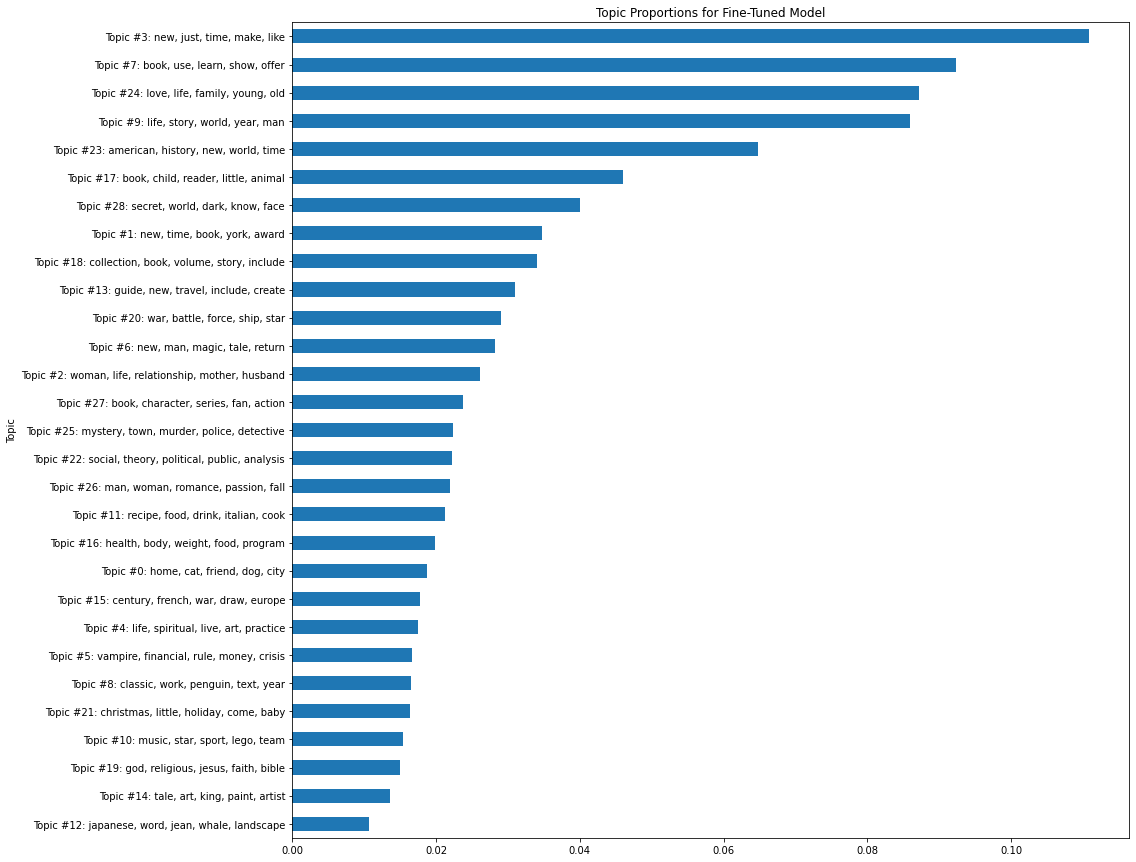

In [ ]:
plot_topic_proportions(tuned, model_name = 'Fine-Tuned Model')

Now, even with a fine-tuned model there are likely to be some inscrutable topics. Look at topic 12 for example: 
what in the world does that represent? Topic 0 has a few less nonsequitors, but from this vantage it's hard to 
discern what it might be about. This, of course, is part of the point of topic modeling: it's a way of helping us 
discover new things about a corpus. Are topics 0 and 12 nonsense topics, or do they have some inner coherence? With 
our model built, it's on us to start exploring.

Exploring a Model
---------------------

In this final section, we'll do just that. It's often helpful to visualize topic mdoels to aid us in our 
explorations, so we'll make a few of these and see what we can find.

Before doing so, let's rebuild a theta from the fine-tuned model. Remember that a theta is a document-topic matrix, 
where each cell is a probability score for a document's association with a particular topic.

In [ ]:
all_topic_distributions = [doc.get_topic_dist() for doc in tuned.docs]
theta = np.stack(all_topic_distributions)
theta /= theta.sum(axis = 1, keepdims = True)
theta = pd.DataFrame(theta, index = manifest['TITLE'])

We'll also make a quick set of labels for our topics, which list the top five words for each one.

In [ ]:
labels = []
for topic in range(tuned.k):
    words = tuned.get_topic_words(topic, top_n = 5)
    words = f"#{topic}: " + ', '.join([w[0] for w in words])
    labels.append(words)

A heatmap is a natural fit for inspecting these probability distributions.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

n_samples = 20
random_titles = manifest['TITLE'].sample(n_samples)
selected_theta = theta[theta.index.isin(random_titles)]

plt.figure(figsize = (15, 8))
ax = sns.heatmap(
    selected_theta,
    xticklabels = labels,
    linewidths = 1,
    linecolor = 'black',
    cmap = 'Blues'
)
ax.set(xlabel = 'Topic', ylabel = 'Title')
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
plt.xticks(rotation = 30, ha = 'left')
plt.tight_layout();

Topic 8 seems to be about the classics. What kind of titles have a particularly high association with this topic?

In [ ]:
topic_8 = theta[theta.idxmax(axis = 1) == 8][8]
selected = manifest[manifest['TITLE'].isin(topic_8.index)]
selected = selected[['AUTHOR', 'TITLE', 'GENRE']].assign(TOPIC_8_SCORE = topic_8.values)
selected.style.hide_index()

Looks about right, though it's interesting to see a few children's books here. Were we to explore this a bit 
further, we'd probably want to take a look at those probability scores. The seeming outliers in this listing also 
tend to have a low score for the topic, so it would be worth investigating whether their other topic associations 
compete with this top score.

Certain topics seem to map very nicely onto particular book genres. Here are some titles associated with topic 11, 
which seems to be about recipes.

In [ ]:
topic_11 = theta[theta.idxmax(axis = 1) == 11][11]
selected = manifest[manifest['TITLE'].isin(topic_11.index)]
selected = selected[['AUTHOR', 'TITLE', 'GENRE']].assign(TOPIC_11_SCORE = topic_11.values)
selected.sample(10).style.hide_index()

And here are a few titles associated with topic 19, which has a lot of religious texts associated with it.

In [ ]:
topic_19 = theta[theta.idxmax(axis = 1) == 19][19]
selected = manifest[manifest['TITLE'].isin(topic_19.index)]
selected = selected[['AUTHOR', 'TITLE', 'GENRE']].assign(TOPIC_19_SCORE = topic_19.values)
selected.sample(10).style.hide_index()

Notice however that you might see contrasting views within these outputs. _The Flying Spaghetti Monster_ is in this 
list of "religious" texts, alongside books like _God: A Biography_ or _Papal Sin_. Topic models, remember, are 
ultimately counting token co-occurences, not the different semantic valences of a word – it's up to use to parse 
the latter. This becomes especially important, for example, when we see overlapping words in topics, as in topics 
10 and 20, where "star" is in the top words for both. Sometimes this can indicate a difference in semantics, other 
times it may indeed be the same sense of the word appearing multiple times.

To parse this difference, it's helpful to examine the overall similarities and differences between topics, much in 
the way we projected our documents into a vector space in the previous chapter. We'll prepare the code to do 
something similar here but will save the final result for a separate webpage. Below, we'll produce the following:

+ A topic-term distribution matrix (word probabilities for each topic)
+ The lengths of every document
+ A list of the corpus vocabulary
+ The corresponding frequency counts for the corpus vocabulary

Once we've made these, we'll prepare our visualization data with a package called `pyLDAvis` and save it.

```{margin} We're saving this, but...
...you could also use `pyLDAvis.display(vis_data)` to show it in your own notebook (it just doesn't play nicely 
with our reader format).
```

In [ ]:
!pip install pyLDAvis

In [ ]:
import pyLDAvis
import warnings
warnings.filterwarnings('ignore')

topic_terms = np.stack([tuned.get_topic_word_dist(k) for k in range(tuned.k)])
doc_lengths = np.array([len(doc.words) for doc in tuned.docs])
vocab = list(tuned.used_vocabs)
term_frequency = tuned.used_vocab_freq

vis_data = pyLDAvis.prepare(
    topic_terms,
    theta.values,
    doc_lengths,
    vocab,
    term_frequency,
    start_index = 0,
    sort_topics = False
)

pyLDAvis.save_html(vis_data, "data/session_three/output/topic_model_plot.html")

With that done, we've finished our initial work with topic models – though the work of exploration has just begun!
You can find the resultant visualization of the above <a href="./topic_model_plot.html">here</a>. It's a 
scatter plot that represents (roughly) topic similarity; the size of each topic circle corresponds to that topic's 
proportion in the model. Play around with it a little bit to see what you can find!